In [1]:
from non_local_detector.likelihoods.sorted_spikes_diffusion_kde import (
    fit_sorted_spikes_diffusion_kde_encoding_model,
)
from non_local_detector.likelihoods.sorted_spikes_kde import (
    fit_sorted_spikes_kde_encoding_model,
)
from non_local_detector.environment import Environment
from non_local_detector.simulate.sorted_spikes_simulation import make_simulated_data
import numpy as np

# 1. simulate
speed, lin_dist, spike_times, time, event_times, fs, is_event, true_pf_time_series = (
    make_simulated_data()
)

# build and fit the Environment
env = Environment(place_bin_size=0.5)
env = env.fit_place_grid(position=lin_dist[:, None])
# std = np.sqrt(12.5)
std = 3.0

# 2. fit your KDE place‑field estimator
model = fit_sorted_spikes_diffusion_kde_encoding_model(
    position_time=time,
    position=lin_dist[:, None],
    spike_times=spike_times,
    environment=env,
    position_std=std,
)
est_pf = np.array(model["place_fields"])  # shape (n_neurons, n_bins)

model2 = fit_sorted_spikes_kde_encoding_model(
    position_time=time,
    position=lin_dist[:, None],
    spike_times=spike_times,
    environment=env,
    position_std=std,
)
est_pf2 = np.array(model2["place_fields"])  # shape (n_neurons, n_bins)

/Users/edeno/Documents/GitHub/non_local_detector/src/non_local_detector/likelihoods/clusterless_kde.py:54: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Computing diffusion kernels...
Computed (342, 342) kernel matrix.
Calculating smoothed occupancy...


Encoding models (Diffusion):   0%|          | 0/25 [00:00<?, ?neuron/s]

Encoding models:   0%|          | 0/25 [00:00<?, ?cell/s]

In [2]:
env.is_track_interior_

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

Text(0.5, 1.0, 'Place field estimation')

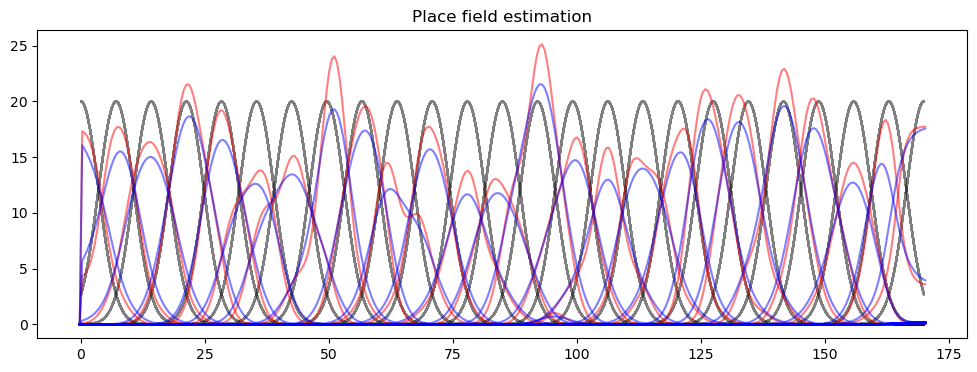

In [3]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(
    lin_dist,
    true_pf_time_series,
    color="k",
    alpha=0.5,
    label="true place field",
)
ax.plot(
    env.place_bin_centers_,
    est_pf.T * fs,
    color="r",
    alpha=0.5,
    label="estimated place field (diffusion)",
)
ax.plot(
    env.place_bin_centers_,
    est_pf2.T * fs,
    color="b",
    alpha=0.5,
    label="estimated place field",
)
plt.title("Place field estimation")

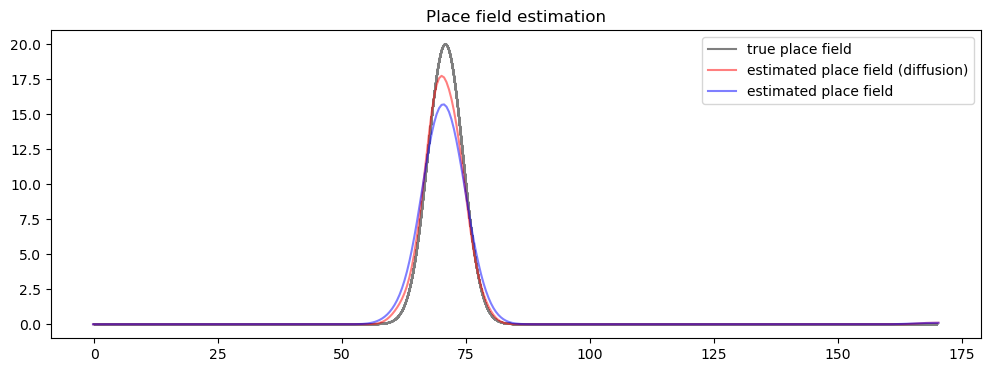

In [4]:
neuron_ind = 10

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(
    lin_dist,
    true_pf_time_series[:, neuron_ind],
    color="k",
    alpha=0.5,
    label="true place field",
)
ax.plot(
    env.place_bin_centers_,
    est_pf[[neuron_ind]].T * fs,
    color="r",
    alpha=0.5,
    label="estimated place field (diffusion)",
)
ax.plot(
    env.place_bin_centers_,
    est_pf2[[neuron_ind]].T * fs,
    color="b",
    alpha=0.5,
    label="estimated place field",
)
plt.title("Place field estimation")
plt.legend()

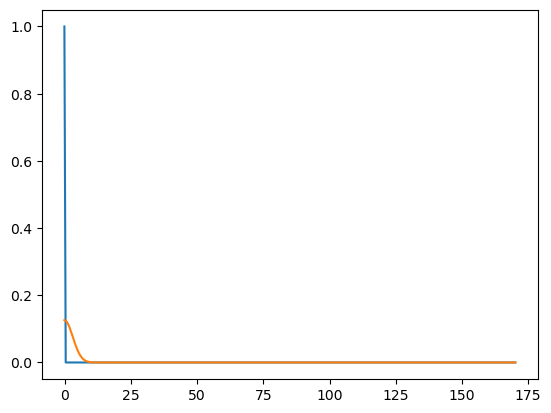

In [7]:
from non_local_detector.diffusion_kernels import compute_diffusion_kernels
from scipy.stats import multivariate_normal


std = 10

diffusion_kernel = compute_diffusion_kernels(
    track_graph=env.track_graph_nd_, interior_mask=None, bandwidth_sigma=std
)

ind = 0

plt.plot(env.place_bin_centers_, diffusion_kernel[ind])
plt.plot(
    env.place_bin_centers_,
    multivariate_normal.pdf(
        env.place_bin_centers_, mean=env.place_bin_centers_[ind], cov=std
    ),
)

In [8]:
from non_local_detector.likelihoods.sorted_spikes_diffusion_kde import (
    predict_sorted_spikes_diffusion_kde_log_likelihood,
)

non_local_likelihood = predict_sorted_spikes_diffusion_kde_log_likelihood(
    time=time,
    spike_times=spike_times,
    position=lin_dist[:, None],
    position_time=time,
    **model,
    is_local=False,
)

local_likelihood = predict_sorted_spikes_diffusion_kde_log_likelihood(
    time=time,
    spike_times=spike_times,
    position=lin_dist[:, None],
    position_time=time,
    **model,
    is_local=True,
)

Calculating non-local likelihood...


Non-Local Likelihood (Diffusion):   0%|          | 0/25 [00:00<?, ?neuron/s]

Calculating local likelihood (nearest interior bin)...


Local Likelihood (Diffusion):   0%|          | 0/25 [00:00<?, ?neuron/s]

ValueError: x and y must have same first dimension, but have shapes (343, 1) and (342,)

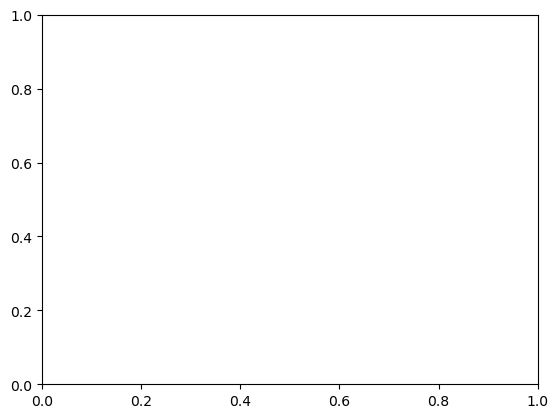

In [9]:
time_ind = 1300

plt.plot(env.place_bin_centers_, non_local_likelihood[time_ind])
plt.axvline(lin_dist[time_ind], color="k", linestyle="--")
plt.scatter(
    lin_dist[time_ind],
    non_local_likelihood[time_ind][int(lin_dist[time_ind] / env.place_bin_size)],
    color="r",
)
plt.scatter(lin_dist[time_ind], local_likelihood[time_ind], color="b")

In [ ]:
env.place_bin_centers_.shape

In [10]:
from track_linearization import make_track_graph

track_graph = make_track_graph([(lin_dist.min(), 0), (lin_dist.max(), 0)], [(0, 1)])

env_track_graph = Environment(
    place_bin_size=10, track_graph=track_graph, edge_order=[(0, 1)]
).fit_place_grid(position=lin_dist[:, None])
env_track_graph.track_graph_with_bin_centers_edges_

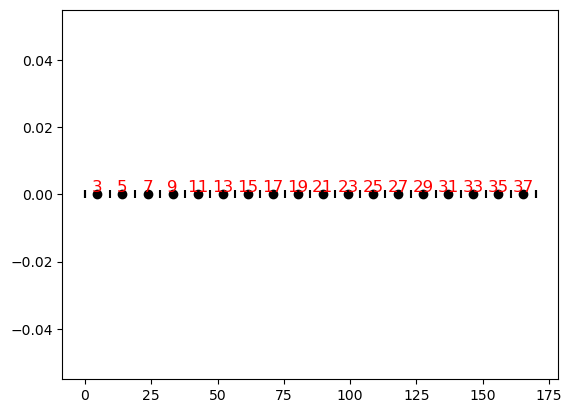

In [11]:
for node_id, node_data in env_track_graph.track_graph_with_bin_centers_edges_.nodes(
    data=True
):
    if node_data["is_bin_edge"]:
        plt.scatter(node_data["pos"][0], node_data["pos"][1], color="k", marker="|")
    else:
        plt.scatter(node_data["pos"][0], node_data["pos"][1], color="k")
        plt.text(
            node_data["pos"][0],
            node_data["pos"][1],
            str(node_id),
            fontsize=12,
            ha="center",
            va="bottom",
            color="red",
        )

In [12]:
nodes_to_remove = [
    node_id
    for node_id, node_data in env_track_graph.track_graph_with_bin_centers_edges_.nodes(
        data=True
    )
    if node_data["is_bin_edge"]
]
nodes_to_remove = set(nodes_to_remove) | set(env_track_graph.track_graph.nodes)

nodes_to_remove_neighbors = [
    list(env_track_graph.track_graph_with_bin_centers_edges_.neighbors(node_id))
    for node_id in nodes_to_remove
]

copy_graph = env_track_graph.track_graph_with_bin_centers_edges_.copy()
for node_id, neighbors in zip(nodes_to_remove, nodes_to_remove_neighbors):
    copy_graph.remove_node(node_id)
    if (
        len(neighbors) == 2
        and neighbors[0] not in nodes_to_remove
        and neighbors[1] not in nodes_to_remove
    ):
        copy_graph.add_edge(neighbors[0], neighbors[1])

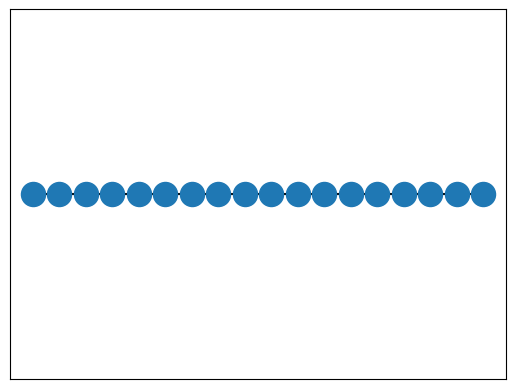

In [13]:
from track_linearization import plot_track_graph

plot_track_graph(copy_graph)

In [14]:
env_track_graph.place_bin_centers_nodes_df_

,node_id,edge_id,is_bin_edge,x_position,y_position,linear_position
0,3,0,False,4.722133,0.0,4.722237
1,5,0,False,14.166606,0.0,14.166710
2,7,0,False,23.611079,0.0,23.611183
3,9,0,False,33.055552,0.0,33.055656
4,11,0,False,42.500025,0.0,42.500129
5,13,0,False,51.944498,0.0,51.944602
6,15,0,False,61.388971,0.0,61.389075
7,17,0,False,70.833444,0.0,70.833548
8,19,0,False,80.277917,0.0,80.278021
9,21,0,False,89.722390,0.0,89.722494


In [15]:
len(copy_graph.nodes), len(env_track_graph.place_bin_centers_nodes_df_)

(18, 18)

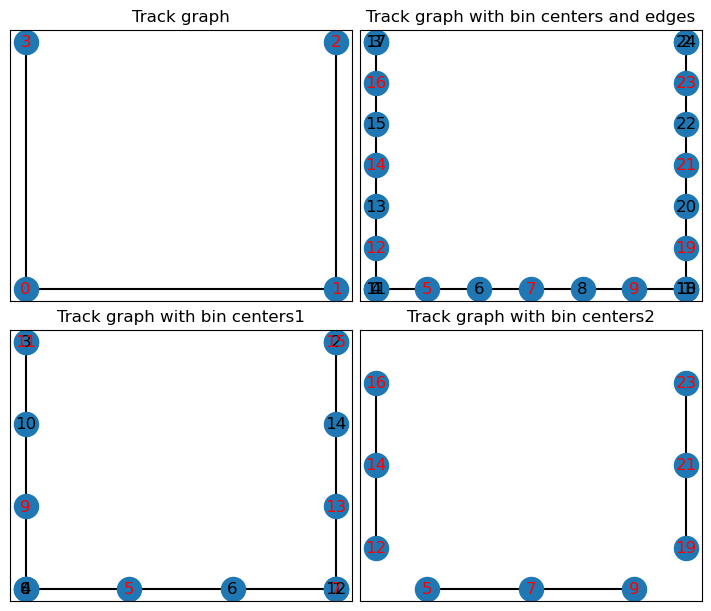

In [16]:
import networkx as nx
from scipy.interpolate import interp1d


def make_track_graph_with_bin_centers_edges(
    track_graph: nx.Graph, place_bin_size: float
) -> nx.Graph:
    """Insert the bin center and bin edge positions as nodes in the track graph.

    Parameters
    ----------
    track_graph : nx.Graph
    place_bin_size : float

    Returns
    -------
    track_graph_with_bin_centers_edges : nx.Graph

    """
    track_graph_with_bin_centers_edges = track_graph.copy()
    n_nodes = len(track_graph.nodes)

    for edge_ind, (node1, node2) in enumerate(track_graph.edges):
        node1_x_pos, node1_y_pos = track_graph.nodes[node1]["pos"]
        node2_x_pos, node2_y_pos = track_graph.nodes[node2]["pos"]

        edge_size = np.linalg.norm(
            [(node2_x_pos - node1_x_pos), (node2_y_pos - node1_y_pos)]
        )
        n_bins = 2 * np.ceil(edge_size / place_bin_size).astype(np.int32) + 1
        if ~np.isclose(node1_x_pos, node2_x_pos):
            f = interp1d((node1_x_pos, node2_x_pos), (node1_y_pos, node2_y_pos))
            xnew = np.linspace(node1_x_pos, node2_x_pos, num=n_bins, endpoint=True)
            xy = np.stack((xnew, f(xnew)), axis=1)
        else:
            ynew = np.linspace(node1_y_pos, node2_y_pos, num=n_bins, endpoint=True)
            xnew = np.ones_like(ynew) * node1_x_pos
            xy = np.stack((xnew, ynew), axis=1)
        dist_between_nodes = np.linalg.norm(np.diff(xy, axis=0), axis=1)

        new_node_ids = n_nodes + np.arange(len(dist_between_nodes) + 1)
        nx.add_path(
            track_graph_with_bin_centers_edges,
            [*new_node_ids],
            distance=dist_between_nodes[0],
        )
        nx.add_path(
            track_graph_with_bin_centers_edges, [node1, new_node_ids[0]], distance=0
        )
        nx.add_path(
            track_graph_with_bin_centers_edges, [node2, new_node_ids[-1]], distance=0
        )
        track_graph_with_bin_centers_edges.remove_edge(node1, node2)
        for ind, (node_id, pos) in enumerate(zip(new_node_ids, xy)):
            track_graph_with_bin_centers_edges.nodes[node_id]["pos"] = pos
            track_graph_with_bin_centers_edges.nodes[node_id]["edge_id"] = edge_ind
            if ind % 2:
                track_graph_with_bin_centers_edges.nodes[node_id]["is_bin_edge"] = False
            else:
                track_graph_with_bin_centers_edges.nodes[node_id]["is_bin_edge"] = True
        track_graph_with_bin_centers_edges.nodes[node1]["edge_id"] = edge_ind
        track_graph_with_bin_centers_edges.nodes[node2]["edge_id"] = edge_ind
        track_graph_with_bin_centers_edges.nodes[node1]["is_bin_edge"] = True
        track_graph_with_bin_centers_edges.nodes[node2]["is_bin_edge"] = True
        n_nodes = len(track_graph_with_bin_centers_edges.nodes)

    return track_graph_with_bin_centers_edges


def make_track_graph_with_bin_centers(
    track_graph: nx.Graph, place_bin_size: float
) -> nx.Graph:
    """Insert the bin center and bin edge positions as nodes in the track graph.

    Parameters
    ----------
    track_graph : nx.Graph
    place_bin_size : float

    Returns
    -------
    track_graph_with_bin_centers_edges : nx.Graph

    """
    track_graph_with_bin_centers_edges = track_graph.copy()
    n_nodes = len(track_graph.nodes)

    for edge_ind, (node1, node2) in enumerate(track_graph.edges):
        node1_x_pos, node1_y_pos = track_graph.nodes[node1]["pos"]
        node2_x_pos, node2_y_pos = track_graph.nodes[node2]["pos"]

        edge_size = np.linalg.norm(
            [(node2_x_pos - node1_x_pos), (node2_y_pos - node1_y_pos)]
        )
        n_bins = 2 * np.ceil(edge_size / place_bin_size).astype(int) + 1
        if ~np.isclose(node1_x_pos, node2_x_pos):
            f = interp1d((node1_x_pos, node2_x_pos), (node1_y_pos, node2_y_pos))
            xnew = np.linspace(node1_x_pos, node2_x_pos, num=n_bins, endpoint=True)
            xnew = xnew[::2]
            xy = np.stack((xnew, f(xnew)), axis=1)
        else:
            ynew = np.linspace(node1_y_pos, node2_y_pos, num=n_bins, endpoint=True)
            ynew = ynew[::2]
            xnew = np.ones_like(ynew) * node1_x_pos
            xy = np.stack((xnew, ynew), axis=1)
        dist_between_nodes = np.linalg.norm(np.diff(xy, axis=0), axis=1)

        new_node_ids = n_nodes + np.arange(len(dist_between_nodes) + 1)
        nx.add_path(
            track_graph_with_bin_centers_edges,
            [*new_node_ids],
            distance=dist_between_nodes[0],
        )
        nx.add_path(
            track_graph_with_bin_centers_edges, [node1, new_node_ids[0]], distance=0
        )
        nx.add_path(
            track_graph_with_bin_centers_edges, [node2, new_node_ids[-1]], distance=0
        )
        track_graph_with_bin_centers_edges.remove_edge(node1, node2)
        for ind, (node_id, pos) in enumerate(zip(new_node_ids, xy)):
            track_graph_with_bin_centers_edges.nodes[node_id]["pos"] = pos
            track_graph_with_bin_centers_edges.nodes[node_id]["edge_id"] = edge_ind
            if ind % 2:
                track_graph_with_bin_centers_edges.nodes[node_id]["is_bin_edge"] = False
            else:
                track_graph_with_bin_centers_edges.nodes[node_id]["is_bin_edge"] = True
        track_graph_with_bin_centers_edges.nodes[node1]["edge_id"] = edge_ind
        track_graph_with_bin_centers_edges.nodes[node2]["edge_id"] = edge_ind
        track_graph_with_bin_centers_edges.nodes[node1]["is_bin_edge"] = True
        track_graph_with_bin_centers_edges.nodes[node2]["is_bin_edge"] = True
        n_nodes = len(track_graph_with_bin_centers_edges.nodes)

    return track_graph_with_bin_centers_edges


def convert_track_graph_with_edges_to_nodes_only(
    track_graph_with_bin_centers_edges, track_graph
) -> nx.Graph:
    """
    Convert a track graph with edges to a graph with nodes only.

    Parameters
    ----------
    env : Environment
        The environment containing the track graph.

    Returns
    -------
    nx.Graph
        A new graph with nodes only, where each node represents a bin.
    """
    copy_graph = track_graph_with_bin_centers_edges.copy()
    nodes_to_remove = [
        node_id
        for node_id, node_data in track_graph_with_bin_centers_edges.nodes(data=True)
        if node_data["is_bin_edge"]
    ]
    nodes_to_remove = set(nodes_to_remove)

    for node_id in track_graph.nodes:
        copy_graph.remove_node(node_id)

    nodes_to_remove_neighbors = [
        list(track_graph_with_bin_centers_edges.neighbors(node_id))
        for node_id in nodes_to_remove
    ]

    for node_id, neighbors in zip(nodes_to_remove, nodes_to_remove_neighbors):
        try:
            copy_graph.remove_node(node_id)
        except nx.NetworkXError:
            # Node already removed
            pass
        if (
            len(neighbors) == 2
            and neighbors[0] not in nodes_to_remove
            and neighbors[1] not in nodes_to_remove
        ):
            copy_graph.add_edge(neighbors[0], neighbors[1])

    return copy_graph


def plot_graph(track_graph, ax=None, ax_title=""):
    plot_track_graph(track_graph, ax=ax)
    for node_id, node_data in track_graph.nodes(data=True):
        try:
            if node_data["is_bin_edge"]:
                ax.text(
                    node_data["pos"][0],
                    node_data["pos"][1],
                    str(node_id),
                    fontsize=12,
                    ha="center",
                    va="center",
                    color="black",
                )
            else:
                ax.scatter(node_data["pos"][0], node_data["pos"][1], color="k")
                ax.text(
                    node_data["pos"][0],
                    node_data["pos"][1],
                    str(node_id),
                    fontsize=12,
                    ha="center",
                    va="center",
                    color="red",
                )
        except KeyError:
            ax.scatter(node_data["pos"][0], node_data["pos"][1], color="k")
            ax.text(
                node_data["pos"][0],
                node_data["pos"][1],
                str(node_id),
                fontsize=12,
                ha="center",
                va="center",
                color="red",
            )
    ax.set_title(ax_title)


x = np.linspace(0, 30)

position = np.concatenate(
    (
        np.stack((np.zeros_like(x), x[::-1]), axis=1),
        np.stack((x, np.zeros_like(x)), axis=1),
        np.stack((np.ones_like(x) * 30, x), axis=1),
    )
)
position += multivariate_normal(mean=0, cov=0.05).rvs(position.shape)

node_positions = [
    (0, 0),  # xy position of node 0
    (30, 0),  # xy position of node 1
    (30, 30),  # xy position of node 2
    (0, 30),  # xy position of node 3
]

edges = [
    (0, 1),  # connects node 0 and node 1
    (0, 3),  # connects node 0 and node 3
    (1, 2),  # connects node 1 and node 2
]

track_graph = make_track_graph(node_positions, edges)

env_track_graph = Environment(
    place_bin_size=10, track_graph=track_graph, edge_order=edges, edge_spacing=1,
).fit_place_grid(position=position)

fig, axes = plt.subplots(
    2, 2, figsize=(7, 6), sharex=True, sharey=True, constrained_layout=True
)
plot_graph(track_graph, ax=axes[0, 0], ax_title="Track graph")

# Create a track graph with bin centers and edges
track_graph_with_bin_centers_edges = make_track_graph_with_bin_centers_edges(
    track_graph, place_bin_size=10
)
plot_graph(
    track_graph_with_bin_centers_edges,
    ax=axes[0, 1],
    ax_title="Track graph with bin centers and edges",
)

# Create a track graph with bin centers and edges
track_graph_with_bin_centers = make_track_graph_with_bin_centers(
    track_graph, place_bin_size=10
)
plot_graph(
    track_graph_with_bin_centers,
    ax=axes[1, 0],
    ax_title="Track graph with bin centers1",
)

track_graph_with_bin_centers = convert_track_graph_with_edges_to_nodes_only(
    track_graph_with_bin_centers_edges, track_graph
)
plot_graph(
    track_graph_with_bin_centers,
    ax=axes[1, 1],
    ax_title="Track graph with bin centers2",
)

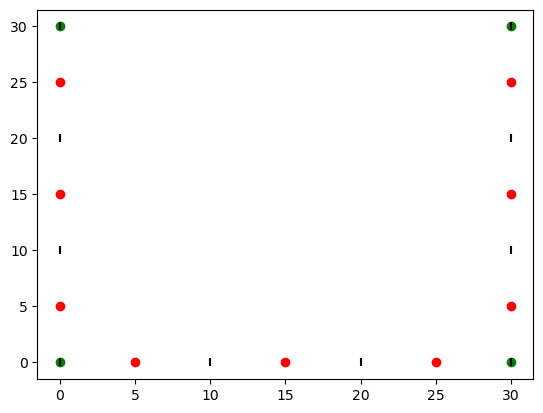

In [17]:
plt.scatter(env_track_graph.place_bin_centers_nodes_df_["x_position"],
            env_track_graph.place_bin_centers_nodes_df_["y_position"],
            color="r",
            label="bin centers",
        )

plt.scatter(
    env_track_graph.place_bin_edges_nodes_df_["x_position"],
    env_track_graph.place_bin_edges_nodes_df_["y_position"],
    color="black",
    label="bin centers",
    marker="|",
)
for node_id, node_data in env_track_graph.track_graph.nodes(data=True):
    plt.scatter(
        node_data["pos"][0],
        node_data["pos"][1],
        color="green",
        zorder=-1,
    )

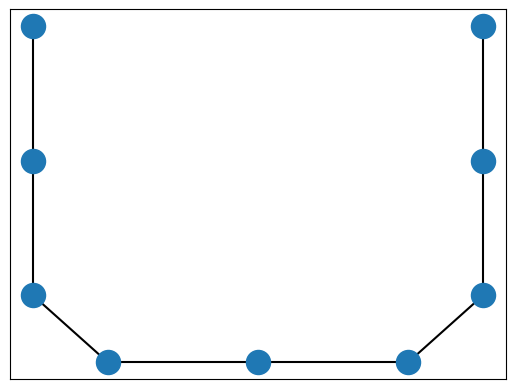

In [18]:
def make_track_graph_with_bin_centers(env):

    track_graph_with_bin_centers = nx.Graph()

    for edge_id, df in env.place_bin_centers_nodes_df_.groupby("edge_id"):
        if edge_id == -1:
            continue
        # sort the dataframe by linear position
        # to ensure the order of nodes in the graph
        df = df.sort_values("linear_position")

        # add the nodes to the graph
        for _, row in df.iterrows():
            track_graph_with_bin_centers.add_node(
                row["node_id"],
                pos=(row["x_position"], row["y_position"]),
                edge_id=edge_id,
            )
        # add the edges to the graph
        for node1, node2 in zip(df["node_id"][:-1], df["node_id"][1:]):
            track_graph_with_bin_centers.add_edge(node1, node2)
            track_graph_with_bin_centers.edges[node1, node2]["distance"] = np.linalg.norm(
                np.array(track_graph_with_bin_centers.nodes[node1]["pos"])
                - np.array(track_graph_with_bin_centers.nodes[node2]["pos"])
            )
            track_graph_with_bin_centers.edges[node1, node2]["edge_id"] = edge_id

    # Link edges
    track_graph_node_to_bin_center = []

    for edge_id, (node1, node2) in enumerate(env.track_graph.edges):

        df = env.place_bin_centers_nodes_df_.loc[
            env.place_bin_centers_nodes_df_.edge_id == edge_id
        ].sort_values("linear_position")
        node1_pos = env.track_graph.nodes[node1]["pos"]
        node2_pos = env.track_graph.nodes[node2]["pos"]

        # find closest nodes in track_graph_with_bin_centers
        closest_node1 = np.argmin(
            np.linalg.norm(
                df[["x_position", "y_position"]].values - np.array(node1_pos),
                axis=1,
            )
        )
        track_graph_node_to_bin_center.append([node1, df.iloc[closest_node1].node_id])

        closest_node2 = np.argmin(
            np.linalg.norm(
                df[["x_position", "y_position"]].values - np.array(node2_pos), axis=1
            )
        )
        track_graph_node_to_bin_center.append([node2, df.iloc[closest_node2].node_id])

    track_graph_node_to_bin_center = np.array(track_graph_node_to_bin_center)

    # Link edges (edge_id, node1) to (edge_id, node2)
    for node_id in np.unique(track_graph_node_to_bin_center[:, 0]):
        is_node = track_graph_node_to_bin_center[:, 0] == node_id
        for node1, node2 in zip(
            track_graph_node_to_bin_center[is_node, 1][:-1],
            track_graph_node_to_bin_center[is_node, 1][1:],
        ):
            track_graph_with_bin_centers.add_edge(node1, node2)
            track_graph_with_bin_centers.edges[node1, node2]["distance"] = np.linalg.norm(
                np.array(track_graph_with_bin_centers.nodes[node1]["pos"])
                - np.array(track_graph_with_bin_centers.nodes[node2]["pos"])
            )

    return track_graph_with_bin_centers

track_graph_with_bin_centers = make_track_graph_with_bin_centers(env_track_graph)

plot_track_graph(
    track_graph_with_bin_centers,
)

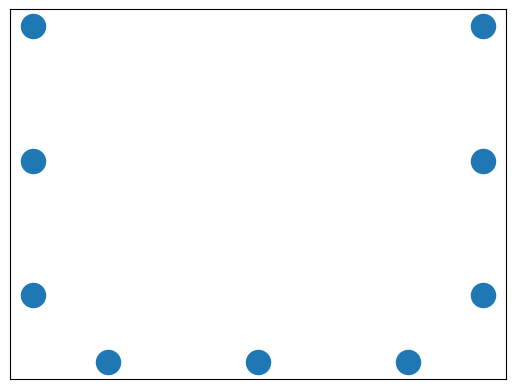

In [19]:
import networkx as nx
import numpy as np
import pandas as pd
from typing import Tuple  # Assuming Environment is imported from your module

# Assuming Environment class definition is available
# from your_module import Environment


def make_track_graph_with_bin_centers_subgraph(env: Environment) -> nx.Graph:
    """Creates a graph connecting only the centers of place bins for a 1D track.

    This function leverages the pre-computed 'track_graph_with_bin_centers_edges_'
    and 'nodes_df_' stored in the fitted Environment object. It extracts the
    nodes corresponding to bin centers and creates an induced subgraph containing
    only these nodes and the edges connecting them in the augmented graph.

    Parameters
    ----------
    env : Environment
        A fitted Environment object for a 1D track
        (must have track_graph attribute).

    Returns
    -------
    track_graph_with_bin_centers : nx.Graph
        A graph where nodes are bin centers and edges connect adjacent
        bin centers along the track. Node attributes include 'pos' and 'edge_id'.
        Edge attributes include 'distance' and 'edge_id'.

    Raises
    ------
    RuntimeError
        If the environment is not fitted or is not a 1D environment.
    ValueError
        If the necessary attributes ('track_graph_with_bin_centers_edges_'
        or 'nodes_df_') are missing from the environment object.
    """
    if not env._is_fitted:
        raise RuntimeError(
            "Environment has not been fitted yet. Call `fit_place_grid` first."
        )
    if env.track_graph is None:
        raise RuntimeError(
            "This function requires a 1D environment (with a track_graph)."
        )
    if env.track_graph_with_bin_centers_edges_ is None or env.nodes_df_ is None:
        raise ValueError(
            "Required attributes 'track_graph_with_bin_centers_edges_' or "
            "'nodes_df_' are missing. Ensure the 1D environment was fitted correctly."
        )

    # Identify nodes that are bin centers (not bin edges)
    bin_center_nodes_df = env.nodes_df_[~env.nodes_df_["is_bin_edge"]]
    bin_center_node_ids = bin_center_nodes_df.node_id.tolist()

    # Create the subgraph containing only bin center nodes and their connecting edges
    # .copy() ensures it's a new graph object, not just a view
    track_graph_with_bin_centers = env.track_graph_with_bin_centers_edges_.subgraph(
        bin_center_node_ids
    ).copy()

    return track_graph_with_bin_centers


track_graph_with_bin_centers = make_track_graph_with_bin_centers_subgraph(
    env_track_graph
)
plot_track_graph(
    track_graph_with_bin_centers,
)

In [ ]:
env_track_graph.nodes_df_

In [ ]:
env_track_graph.track_graph.edges